<a href="https://colab.research.google.com/github/LivroRelampagos/Estudo_de_Caso/blob/main/latlon_slice_lagrangeano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Plota Corte vertical de tempestade + relâmpagos**

---

**OBJETIVO:** O objetivo desse colab é fazer um corte vertical em latitude e longitude de uma imagem do radar da FCTH. São utilizados dados da campanha CHUVA-VALE para uma determinada tempestade.

---

**DADOS DE ENTRADA**: Dados de radar e relâmpagos. 

1. **Radar**:

- **Tipo do dado:** Radar do FCTH durante a campanha CHUVA-Vale
- **Formato do dado:** arquivos binários de 3 a 15 km de altura
- **Nome do arquivo:** cappi_CZ_03000_20111213_2210.dat.gz/cappi_CZ_15000_20111213_2210.dat.gz
- **Gerado por:** Thiago Biscaro - CPTEC/INPE 

2. **Relâmpagos**:

- **Tipo do dado:** Dados de relâmpagos da SPLMA e BrasilDAT durante a campanha CHUVA-Vale
- **Formato do dado:** arquivo ASCII
- **Nome do arquivo:** tempestade_7_20120109_1743.csv
- **Gerado por:** Enrique Mattos - IRN/UNIFEI


    
---

- **METODOLOGIA:** Nessa aula realizaremos os seguintes procedimentos:

    1.   **Instalação** das bibliotecas adicionais
    2.   **Importação** das biblotecas
    3.   Montagem do **drive online**
    5.   **Importação** de funções 
    6.   **Leitura** CAPPIs do radar e transforma em NETCDF
    7.   Processa os dados de relâmpagos
    8.   **Plota** CAPPI 3 km e 2 slices (lat e lon)
    
---


**OBSERVAÇÕES IMPORTANTES**: 
1. Fazer mudanças, veja em: **### >>> MUDANÇAS AQUI <<< ###**
    - 1. Caminho do seu drive 
    - 2. Número da tempestade
    - 3. Data e hora da imagem do slice

---

- **Realizado por:** Enrique V. Mattos - 11/dez/2021 
- **Atualizado por:** Enrique V. Mattos e Raquel Gonçalves Pereira - 10/03/2022

# **### >>> MUDANÇAS AQUI <<< ###**

- **Insira o caminho do seu drive**: alterar aqui

In [ ]:
dir = '/content/drive/MyDrive/Mestrado/LIVRO_RAQUEL/'

- **Defina o horário da imagem**: alterar aqui

In [ ]:
anox, mesx, diax, horx, minx = '2012', '01', '09', '17', '43'

- **Caminhos dos diretórios**: aqui não precisa alterar

In [ ]:
# definindo os caminhos 
path_input = f'{dir}1_rastreamento_tempestades_radar_FCTH/output/'  # caminho do arquivo de rastreamento da tempestade
path_output = f'{dir}8_corte_vertical/output/' # caminho onde as figuras serão salvas

# definindo os diretórios dos dados de radar, splma e brasildat 
dir_dados_radar = f'{dir}dados_radar_fcth/' # diretório dos dados de RADAR
dir_dados_splma = f'{dir}dados_splma/' # diretório dos dados de relâmpagos da SPLMA
dir_dados_brasildat = f'{dir}dados_brasildat/' # diretório dos dados de relâmpagos da BRASILDAT

# definindo o diretório dos shapefiles 
dir_shapefiles = f'{dir}shapefiles/' # diretório dos arquivo de shapefiles

# exibe na tela
print(path_input)
print(path_output)

/content/drive/MyDrive/Mestrado/LIVRO_RAQUEL/1_rastreamento_tempestades_radar_FCTH/output/
/content/drive/MyDrive/Mestrado/LIVRO_RAQUEL/8_corte_vertical/output/


# **Instalando as bibliotecas**

In [ ]:
# Instalando o cartopy (usado para gerar Mapas)
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install --no-binary shapely shapely --force
!pip install cartopy
print('\n')

# Instalando o proplot (usado para gerar Mapas também)
!pip install proplot==0.6.4
print('\n')

# Instalando o py_art (biblioteca para trabalhar com dados de radar)
!pip install arm_pyart
print('\n')

!pip install pyproj
!pip install obspy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (94.9 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state

# **Importando as bibliotecas**

**importa bibliotecas**

In [ ]:
import pyart
import xarray as xr
import numpy as np
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopy                                # Biblioteca para geocodificação
from geopy import distance
import pyart
import os
import cartopy.io.shapereader as shpreader  # Biblioteca para ler arquivos shapefiles 
import gzip
import zipfile
import shutil
from datetime import datetime
import tarfile
import glob

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.divide(0.4, 1, casting="unsafe", dtype=np.float),
/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import regist

Mounted at /content/drive


**monta drive para salvar arquivos de saída**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Cria a pasta para as figuras de sáida**

In [ ]:
import os
os.makedirs(f'{path_output}', exist_ok=True)

# **Importando as funções**

In [ ]:
#----------------------------------------------------------------------------------- 
#  Função que plota circulos de distância em geral 
#----------------------------------------------------------------------------------- 
def evm_plota_aneis_em_geral(aneis, lon_r, lat_r, color, label):

    """
    Retorna círculos de distância centrado no radar

    Parâmetros de entrada:
                aneis (lista): tamanho do raio do círculo em km 
                lon_r (float): valor da longitude do centro do círculo em graus  
                lat_r (float): valor da latitude do centro do círculo em graus 
                color (str): cor do raio do círculo
                label (str): legenda    

    Parâmetros de saída:
                latitude e longitude que delimita círculos de distância centrado no radar e plota os círculos
    """

    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((len(aneis), 361))
    lats = np.zeros((len(aneis), 361))
    for i, dis in enumerate(aneis):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]   

    for i, anel in enumerate(aneis):
        ax1.plot(lons[i,:], lats[i,:], color=color, label= label, linestyle='--')

#----------------------------------------------------------------------------------- 
# Função que plota os Estados 
#----------------------------------------------------------------------------------- 
def evm_plot_states(shapefile):
    
    """
    Retorna a plotagem dos contornos de um shapefile na figura

    Parâmetros de entrada:
                shapefile (shp): shapefile da regiao 
                
    Parâmetros de saída:
                figura com o contorno da região baseado no shapefile fornecido
    """

    shapefile = list(shpreader.Reader(shapefile).geometries())
    ax1.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=1.0)  

#-----------------------------------------------------------------------------------   
# Leitura dos dados de raios por imagem de radar 
#----------------------------------------------------------------------------------- 
def read_raios_porimagem(filename):

    ''' Função para ler os dados de relâmpagos da Brasildat e SPLMA separados por imagem de radar

    Exemplo do dado:
            INI_FLASH_LMA=55;Fontes=2
            area(km2);duracao(s);comprimento(km);ano;mes;dia;hor;min;seg;lat;lon;alt(m) 
            52.55;0.197991;7.25;2011;12;13;22;19;56.339645;-24.1650;-47.4339;7567.9000
            52.55;0.197991;7.25;2011;12;13;22;19;56.368057;-24.1565;-47.4044;8132.4000
            END_FLASH_LMA 

            INI_FLASH_BRASILDAT=3
            tipo;ano;mes;dia;hor;min;seg;lat;lon;pc(kA) 
            IC;2011;12;13;22;19;21.755556;-24.1796;-47.4274;4.4000
            IC;2011;12;13;22;19;21.778186;-24.1503;-47.4200;8.2000
            IC;2011;12;13;22;19;23.290068;-24.1121;-47.4872;5.3000
            END_FLASH_BRASILDAT   

    Parâmetros:
                filename (string): nome do arquivo com os dados de relâmpagos
                
    Retorna:
             dic_br (dicionario): dicionario com as informações dos relâmpagos da Brasildat
             dic_lma (dicionario): dicionario com as informações dos relâmpagos da SPLMA
    '''

    # Define variaveis da Brasildat
    tipo_br, ano_br, mes_br, dia_br, hor_br, min_br, seg_br, lat_br, lon_br, pc_br = [], [], [], [], [], [], [], [], [], []

    # Define os dicionários que serão alojados os dados da Brasildat e SPLMA
    dic_br = {}
    dic_lma = {}
    nflashes_lma = 0 # quantidade de relâmpagos da SPLMA do arquivo

    # Leitura do arquivo 
    with open(filename, 'r') as file:
        rawdata = file.readlines()

    # Extrai as informações do arquivo 
    for i in range(len(rawdata)):

        # quebra a linha onde tem ';' e coloca numa lista
        linha = rawdata[i].split(';')
    
        # identificando o tipo de linha
        if len(linha) == 0:
            pass

        # LINHA DA BRASILDAT
        elif linha[0][0:19] == 'INI_FLASH_BRASILDAT':

            # extrai a quantidade de relâmpagos
            lixo, nbr = linha[0].strip().split('=')

            # loop dos relâmpagos da brasildat
            for ii in range(i+2, i+2+int(nbr), 1):
                tipo, ano, mes, dia, hor, min, seg, lat, lon, pc = rawdata[ii].strip().split(';')
                tipo_br.append(tipo)
                ano_br.append(ano)
                mes_br.append(mes)
                dia_br.append(dia)
                hor_br.append(hor)
                min_br.append(min)
                seg_br.append(seg)
                lat_br.append(lat)
                lon_br.append(lon)
                pc_br.append(pc)

            # coloca as informações dos relãmpagos da brasildat num dicionário
            dic_br = {'tipo': tipo_br,
                      'ano': ano_br,
                      'mes': mes_br,
                      'dia': dia_br,
                      'hor': hor_br,
                      'min': min_br,
                      'seg': seg_br,
                      'lat': lat_br,
                      'lon': lon_br,
                      'pc': pc_br
                      } 

        # LINHA DA SPLMA
        elif linha[0][0:13] == 'INI_FLASH_LMA':

            # extrai o número do flash e quantidade de fontes
            lixo, flash_id = linha[0].split('=')
            lixo, nfontes = linha[1].strip().split('=')
            nflashes_lma = flash_id
            flash_id = 'flash' + str(flash_id)

            #print('aki', flash_id, nfontes)
        
            # loop nas fontes daquele flash
            area_lma, dur_lma, comp_lma, ano_lma, mes_lma, dia_lma, hor_lma, min_lma, seg_lma, lat_lma, lon_lma, alt_lma = [], [], [], [], [], [], [], [], [], [], [], []
            for jj in range(i+2, i+2+int(nfontes), 1):
                area0, dur0, comp0, ano0, mes0, dia0, hor0, min0, seg0, lat0, lon0, alt0 = rawdata[jj].strip().split(';')
            
                area_lma = area0
                dur_lma = dur0
                comp_lma = comp0
                ano_lma.append(ano0)
                mes_lma.append(mes0)
                dia_lma.append(dia0)
                hor_lma.append(hor0)
                min_lma.append(min0)
                seg_lma.append(seg0)
                lat_lma.append(lat0)
                lon_lma.append(lon0)
                alt_lma.append(alt0)

            # colocar as informações do flash num dicionário
            # self.family_data.update({actual_family_id: {'header': [], 'evolution': [], 'ending_line': []}})
            ###dic_lma.update({flash_id: {'alt': alt0}})
            dic_lma.update({flash_id: { 'fontes': nfontes, 
                                        'area': area_lma, 
                                        'dur': dur_lma,
                                        'comp': comp_lma, 
                                        'ano': ano_lma, 
                                        'mes': mes_lma, 
                                        'dia': dia_lma, 
                                        'hor': hor_lma, 
                                        'min': min_lma, 
                                        'seg': seg_lma, 
                                        'lat': lat_lma, 
                                        'lon': lon_lma,
                                        'alt': alt_lma
                            }})

    return dic_br, dic_lma, int(nbr), int(nflashes_lma)

#----------------------------------------------------------------------------------- 
#  Função que calcula a distância entre 2 pontos 
#-----------------------------------------------------------------------------------  
def get_distance_and_azimuth(lon1, lat1, lon2, lat2):
    
    """
    Função que calcula a distância (km) e azimute (graus) entre dois pontos

    Parâmetros:
                lat1 (float): latitude em graus do ponto 1
                lon1 (float): longitude em graus do ponto 1
                lat2 (float): latitude em graus do ponto 2
                lon2 (float): longitude em graus do ponto 2
                
    Retorna:
             fwd_azimuth (float): ângulo azimute "para frente" em graus 
             back_azimuth (float): ângulo azimute "para trás" em graus  
             distancia_km (float): distância em km entre o ponto 1 (lat1, lon1) e ponto 2 (lat2, lon2)
    """

    import pyproj

    geodesic = pyproj.Geod(ellps='WGS84')

    fwd_azimuth_graus, back_azimuth_graus, distance_m = geodesic.inv(lon1, lat1, lon2, lat2)

    distance_km = distance_m/1000.
    
    return distance_km, fwd_azimuth 

#----------------------------------------------------------------------------------- 
#            Função que calcula a lat/lon do ponto 2 
#----------------------------------------------------------------------------------- 
def calc_latlon_from_distance(lat1, lon1, distancia, azimute):
    
    """
    Função que calcula a latitude e longitude de um segundo ponto, a partir 
    de uma localização central, distância e azimute

    Parâmetros:
                lat1 (float): latitude em graus do ponto 1
                lon1 (float): longitude em graus do ponto 1
                distancia (float): distância em km entre o ponto 1 e 2
                azimute (float): azimute entre o ponto 1 e 2
                
    Retorna:
             lat2 (float): latitude em graus do ponto 2
             lon2 (float): longitude em graus do ponto 2
    """
 
    # importa funções
    import geopy
    from geopy import distance

    # define localização do ponto central
    lat_central = lat1
    lon_central = lon1

    # define distância
    distancia = distancia

    # define azimute
    azimute = azimute

    # given: lat1, lon1, b = bearing in degrees e d = distance in kilometers
    origin = geopy.Point(lat_central, lon_central)

    # calcula latitude e longitude do ponto 2
    destination = distance.distance(kilometers=distancia).destination(origin, azimute)
    lat2, lon2 = destination.latitude, destination.longitude

    return lat2, lon2

#----------------------------------------------------------------------------------- 
#  Função que calcula a distância de um ponto e uma reta 
#-----------------------------------------------------------------------------------   
def get_point_line_distance(point_x, point_y, line_s_x, line_s_y, line_e_x, line_e_y):

    """
    Função que calcula a distância entre um ponto e uma reta

    Parâmetros:
                point_x (float): longitude em graus do ponto 
                point_y (float): latitude em graus do ponto
                
                line_s_x (float): longitude em graus do primeiro ponto da reta
                line_s_y (float): latitude em graus do primeiro ponto da reta
                
                line_e_x (float): longitude em graus do último ponto da reta
                line_e_y (float): latitude em graus do último ponto da reta
                
    Retorna:
             distancia_km (float): distância em km entre o ponto e a reta
    """
    
    import math
    from obspy.geodetics import degrees2kilometers

    #point_x = point[0]
    #point_y = point[1]

    #line_s_x = line[0][0]
    #line_s_y = line[0][1]

    #line_e_x = line[1][0]
    #line_e_y = line[1][1]

    # If the line is parallel to the y-axis, the distance is the absolute value of the 
    # difference between the x-coordinate of the point and the x-coordinate of any point on the line
    if line_e_x - line_s_x == 0:
        distancia_graus = math.fabs(point_x - line_s_x)
        return degrees2kilometers(distancia_graus)

    # If the line is parallel to the x-axis, the distance is the absolute value of the 
    # difference between the y-coordinate of the point and the y-coordinate of any point on the line
    elif line_e_y - line_s_y == 0:
        distancia_graus =  math.fabs(point_y - line_s_y)
        return degrees2kilometers(distancia_graus)

    else:
        # Slope
        k = (line_e_y - line_s_y) / (line_e_x - line_s_x)

        # Intercept
        b = line_s_y - k * line_s_x

        # Bring in the formula to get the distance dis
        distancia_graus = math.fabs(k * point_x - point_y + b) / math.pow(k * k + 1, 0.5)

        # transforma distância de graus para km
        return degrees2kilometers(distancia_graus)

def seleciona_raios_perto_da_reta_do_slice(lon1, lat1, lon2, lat2, lon_raio, lat_raio, alt_raio, dist_raio_reta):

    # longitudes e latitudes dos pontos 1 e 2 que limitam a reta
    #lon1, lat1, lon2, lat2 = lonmin_figa, lat_slice, lonmax_figa, lat_slice

    # dados de raios
    #lon_raio, lat_raio, alt_raio = lon_lma, lat_lma, alt_lma

    # Loop das linhas dos relâmpagos
    lon_raio2, lat_raio2, alt_raio2 = [], [], []
    for ilat, ilon, ialt in zip(lat_raio, lon_raio, alt_raio):

        # calcula distância entre ponto e reta
        distancia_km = get_point_line_distance(ilon, ilat, lon1, lat1, lon2, lat2)
        #print(distancia_km, ilon, ilat, lon1, lat1, lon2, lat2)

        # seleciona o relâmpago que esta < 3 km da reta
        if distancia_km <= dist_raio_reta:
            lon_raio2.append(ilon)
            lat_raio2.append(ilat)
            alt_raio2.append(ialt)
    
    return lon_raio2, lat_raio2, alt_raio2

# **Descompactando os dados de radar**

In [ ]:
#-------------------------------------------------------#
#                     RADAR
#-------------------------------------------------------#
# Descompactando os dados do radar
print('destargeando arquivos do RADAR ---> ')
filename = 'cappi_CZ_radar_FCTH_2012-01-09.tar.gz'

tar_file = tarfile.open(f'{dir_dados_radar}{filename}')
tar_file.getnames()
tar_file.extractall()

#-------------------------------------------------------#
#                     SPLMA
#-------------------------------------------------------#
# Descompactando os dados do splma
print('destargeando arquivos da rede SPLMA ---> ')
filename = 'splma_2012-01-09_level2.tar.gz'

tar_file = tarfile.open(f'{dir_dados_splma}{filename}')
tar_file.getnames()
tar_file.extractall()

destargeando arquivos do RADAR ---> 
destargeando arquivos da rede SPLMA ---> 


# **Informações do radar**

In [ ]:
# número de colunas e linhas da matriz do radar
nz, nx, ny = 13, 500, 500

# área da matriz do radar
lonmin, lonmax, latmin, latmax = -48.4564, -43.4780, -25.8367, -21.3360 

# localização do radar
lat_radar, lon_radar = -23.6000, -45.9722

# resolução espacial em graus da lat e lon (=0.01 graus)
dx = (lonmax-lonmin)/(nx-1)
dy = (latmax-latmin)/(ny-1)
dz = 1. #(=1000 metros)

# cria matriz de latitudes e longitudes
lat = np.linspace(latmin, latmax, ny) 
lon = np.linspace(lonmin, lonmax, nx)

# reprojeta as lons e lats do radar para uma matriz bidimensional
lon, lat = np.meshgrid(lon, lat)

# vetor de altura (em metros)
alt_min, alt_max = 3., 15.
alts = np.linspace(alt_min, alt_max, nz)

# cria matriz de latitudes e longitudes para arquivo netcdf
#lons = np.arange(lonmin, lonmax, dx)
#lats = np.arange(latmax, latmin, -dy)
lats = np.linspace(latmin, latmax, ny) 
lons = np.linspace(lonmin, lonmax, nx)
alts

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.])

#**1) Gera arquivo Netcdf**

In [ ]:
# ===================================================================================== #  
#                         Lista das alturas dos CAPPIs de 3 a 15 km de altura
# ===================================================================================== # 
files = [f'/content/cappi_CZ_{str(i*1000).zfill(5)}_{anox}{mesx}{diax}_{horx}{minx}.dat.gz' for i in range(3, 16)]

# ===================================================================================== #  
#                             Processamento
# ===================================================================================== # 
cappi_3d = np.zeros((nz, ny, nx)) # cappi_3d[alturas, latitudes, longitudes])

#-------------------------------------------  
# Loops dos CAPPI (3-15 km) daquele horário
#-------------------------------------------
for i, file in enumerate(files):
    
    print('...PROCESSANDO----->>>>>>', i, file)

    # descompacta o arquivo
    with gzip.open(file, 'rb') as entrada:
        with open(file[0:-3], 'wb') as saida:
            shutil.copyfileobj(entrada, saida) 

    # leitura do arquivo binário
    dados0 = np.fromfile(file[0:-3], np.float32)

    # reprojeta o dado de 1D para matriz 2D
    dados1 = dados0.reshape(ny, nx)

    # Salva na matriz 3D de cappi  
    cappi_3d[i,:,:] = dados1[:,:]
    #print(dados1.min(), dados1.max())
    #print(cappi_3d.min(), cappi_3d.max())

#-------------------------------------------  
#          Mascara as refletividades
#-------------------------------------------
cappi_3d = np.ma.masked_array(cappi_3d, cappi_3d < 0)
#cappi_3d[ (cappi_3d == -99.0) ] = 0.0

# Transforma de dbz para mm6/mm3 
zh_3d = 10**(cappi_3d/10.)
#-------------------------------------------

#-------------------------------------------  
#         Salva em arquivo Netcdf
#-------------------------------------------  
# cria DataSet
data_vars = {'refletividade':(('Altura', 'Latitude', 'Longitude'), cappi_3d, {'units': 'dBZ', 'long_name':'Refletividade'})}
coords = {'Altura': alts, 'Latitude': lats, 'Longitude': lons}
attrs = {'creation_data':str(datetime.now()), 'author':'Enrique V. Mattos', 'email': 'enrique.vmattos@gmail.com'}
ds = xr.Dataset(data_vars=data_vars, coords=coords, attrs=attrs)

# salva arquivo netcdf
#ds.to_netcdf(f'{dir}cappi3d_CZ_FCTH_{ano}{mes}{dia}_{hor}{min}.nc')

...PROCESSANDO----->>>>>> 0 /content/cappi_CZ_03000_20120109_1743.dat.gz
...PROCESSANDO----->>>>>> 1 /content/cappi_CZ_04000_20120109_1743.dat.gz
...PROCESSANDO----->>>>>> 2 /content/cappi_CZ_05000_20120109_1743.dat.gz
...PROCESSANDO----->>>>>> 3 /content/cappi_CZ_06000_20120109_1743.dat.gz
...PROCESSANDO----->>>>>> 4 /content/cappi_CZ_07000_20120109_1743.dat.gz
...PROCESSANDO----->>>>>> 5 /content/cappi_CZ_08000_20120109_1743.dat.gz
...PROCESSANDO----->>>>>> 6 /content/cappi_CZ_09000_20120109_1743.dat.gz
...PROCESSANDO----->>>>>> 7 /content/cappi_CZ_10000_20120109_1743.dat.gz
...PROCESSANDO----->>>>>> 8 /content/cappi_CZ_11000_20120109_1743.dat.gz
...PROCESSANDO----->>>>>> 9 /content/cappi_CZ_12000_20120109_1743.dat.gz
...PROCESSANDO----->>>>>> 10 /content/cappi_CZ_13000_20120109_1743.dat.gz
...PROCESSANDO----->>>>>> 11 /content/cappi_CZ_14000_20120109_1743.dat.gz
...PROCESSANDO----->>>>>> 12 /content/cappi_CZ_15000_20120109_1743.dat.gz


In [ ]:
cappi_3d

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        ...,

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --,

In [ ]:
ds

<xarray.Dataset>
Dimensions:        (Altura: 13, Latitude: 500, Longitude: 500)
Coordinates:
  * Altura         (Altura) float64 3.0 4.0 5.0 6.0 7.0 ... 12.0 13.0 14.0 15.0
  * Latitude       (Latitude) float64 -25.84 -25.83 -25.82 ... -21.35 -21.34
  * Longitude      (Longitude) float64 -48.46 -48.45 -48.44 ... -43.49 -43.48
Data variables:
    refletividade  (Altura, Latitude, Longitude) float64 nan nan nan ... nan nan
Attributes:
    creation_data:  2022-03-21 22:55:28.888057
    author:         Enrique V. Mattos
    email:          enrique.vmattos@gmail.com

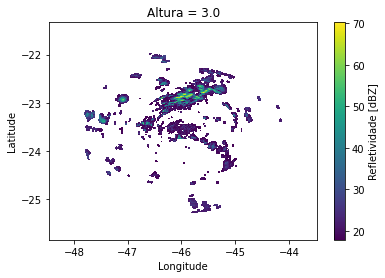

In [ ]:
teste=ds['refletividade'][0,:,:].plot()

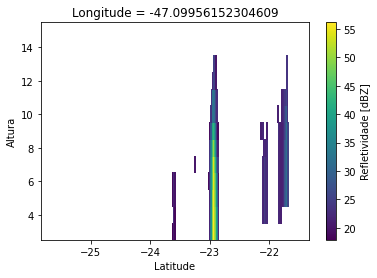

In [ ]:
ds['refletividade'].sel(Longitude=-47.1, method='nearest').plot()

#**2) Processamento dos dados de relâmpagos**

- **Leitura do dado**

In [ ]:
# nome do arquivo
file_raio = filename = f'{path_input}tempestade_{anox}{mesx}{diax}_{horx}{minx}.csv' # tempestade_1_20120107_1452.csv

# leitura do arquivo ASCII de relâmpagos
dic_br, dic_lma, nstrokes_br, nflashes_lma = read_raios_porimagem(file_raio)

- **Cálculos**: salva a lat, lon e altitude da primeira fonte do flash

In [ ]:
# declara variáveis que guardarão
# as lats, lons e alts da primeira fonte do flash
lat_lma, lon_lma , alt_lma = [], [], []

# processamento
total_fontes = 0
if nflashes_lma > 0:

    # Loop em cada relâmpago da SPLMA
    for i in range(1, nflashes_lma+1):
        
        # monta a identificação do flash (exemplo: "flash1")
        flash_id = 'flash' + str(i)
          
        # extrai a latitude e longitude da primeira fonte do flash
        lat0 = float(dic_lma[f'{flash_id}']['lat'][0])
        lon0 = float(dic_lma[f'{flash_id}']['lon'][0])
        alt0 = (float(dic_lma[f'{flash_id}']['alt'][0]))/1000.

        # guarda a lat0 e lon0 numa lista
        lat_lma.append(lat0)
        lon_lma.append(lon0)
        alt_lma.append(alt0)

# transforma lat, lon e alt de string para float
lon_br = [ float(item) for item in dic_br['lon'] ]
lat_br = [ float(item) for item in dic_br['lat'] ]
alt_br = list(np.ones(len(lat_br))*3.5)  

#**3) Plota 2 slices**: RADAR FCTH
- https://xarray.pydata.org/en/stable/user-guide/plotting.html

- **Definição dos limites do gráficos**

In [ ]:
#---------------------------------------------#
#      latitude e longitude do slice
#---------------------------------------------#
lat_slice = -22.92

lon_slice = -47.04

dist_raio_reta = 2.0  # 2km

#---------------------------------------------#
#       limites dos eixos X e Y dos gráficos
#---------------------------------------------#
lonmin_figa, lonmax_figa , latmin_figa, latmax_figa = -47.4, -46.8, -23.2, -22.6 # figura a)

lonmin_figb, lonmax_figb = -47.4, -46.8 # figura b)

latmin_figc, latmax_figc = -23.2, -22.6 # figura c)

altmin_fig, altmax_fig = 3., 15. # figura que tem altura (a e b)

- **Plota figura**

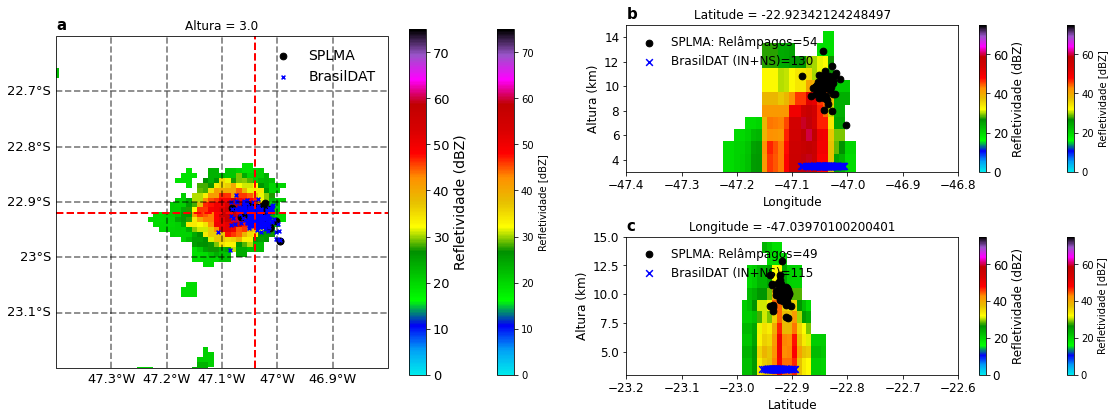

In [ ]:
# nome do radar
nome_radar = 'FCTH'

#---------------------------------------------#
#         formatação do gráfico
#---------------------------------------------#
# cria moldura da figura
fig = plt.figure(figsize=[18,6])

# seta projeção da figura
projection = ccrs.PlateCarree()

# tamanho de cada sub-gráfico (a, b e c)
dy=0.04
map_panel_axes = [0.05, 0.12, .4, .80]
y_cut_panel_axes = [0.49, 0.50+dy+0.05, 0.4, 0.25+dy+0.05] # slice de cima
x_cut_panel_axes = [0.49, 0.10+dy-0.04+0.02, 0.4, 0.25+dy+0.01+0.02] # slice de baixo

#---------------------------------------------#
#            seta parâmetros
#---------------------------------------------#
cmap ='pyart_NWSRef'
level = 0
vmin = 0.  # dBZ
vmax = 75. # dBZ

#---------------------------------------------#
#     Painel a): CAPPI plot of the first tilt
#---------------------------------------------#
# define eixo
ax1 = fig.add_axes(map_panel_axes, projection=projection)

# plota radar
painel_a= ds['refletividade'][0,:,:].plot.imshow(cmap=cmap, vmin=vmin, vmax=vmax)

#plota barra de cores 
cbar = plt.colorbar(painel_a)
cbar.set_label(label='Refletividade (dBZ)', size=14)
cbar.ax.tick_params(labelsize=13)


# plota linhas horizontal e vertical
ax1.axhline(y=lat_slice, color='red', linestyle='--', lw=2.0)
ax1.axvline(x=lon_slice, color='red', linestyle='--', lw=2.0)

# plota LMA
ax1.scatter(lon_lma, lat_lma, transform=ccrs.PlateCarree(), marker='o', s=45, color='black', label=f'SPLMA') 

# plota BRASILDAT
ax1.scatter(lon_br, lat_br, transform=ccrs.PlateCarree(), marker='x', s=15, color='b', label=f'BrasilDAT') 

# plota contornos
evm_plot_states(f'{dir_shapefiles}BR_UF_2019.shp')
evm_plot_states(f'{dir_shapefiles}shapefile_rmsp.shp')

# plota os aneis de distância do radar
#evm_plota_aneis_em_geral([20, 50, 100], lon_radar, lat_radar, 'gray', label='Radar: 190 km')

# formatação dos eixos
ax1.set_title('a', color='black', fontsize=15, fontweight='bold', loc='left') 
ax1.set_xlim([lonmin_figa, lonmax_figa])
ax1.set_ylim([latmin_figa, latmax_figa])

# get the current axes and plot some lat and lon lines
ax1 = plt.gca()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.7, color='black', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

# legenda
ax1.legend(loc='lr', frameon=False, prop={'size':14})

#---------------------------------------------#
#      Painel c): longitude slice
#---------------------------------------------#
# define eixo
ax2 = fig.add_axes(x_cut_panel_axes)

# plota radar
painel_c =ds['refletividade'].sel(Longitude=lon_slice, method='nearest').plot.imshow(cmap=cmap, vmin=vmin, vmax=vmax)

#plota barra de cores 
cbar = plt.colorbar(painel_c)
cbar.set_label(label='Refletividade (dBZ)', size=12)
cbar.ax.tick_params(labelsize=12)


# plota LMA
lon1, lat1, lon2, lat2 = lon_slice, latmin_figa, lon_slice, latmax_figa # longitudes e latitudes dos pontos 1 e 2 que limitam a reta
lon_raio, lat_raio, alt_raio = lon_lma, lat_lma, alt_lma                # dados de raios
lon_raio2, lat_raio2, alt_raio2 = seleciona_raios_perto_da_reta_do_slice(lon1, lat1, lon2, lat2, lon_raio, lat_raio, alt_raio, dist_raio_reta)
ax2.scatter(lat_raio2, alt_raio2, marker='o', s=45, color='black', label=f'SPLMA: Relâmpagos={int(len(lon_raio2))}') # Lma

# plota BRASILDAT
lon1, lat1, lon2, lat2 = lon_slice, latmin_figa, lon_slice, latmax_figa # longitudes e latitudes dos pontos 1 e 2 que limitam a reta
lon_raio, lat_raio, alt_raio = lon_br, lat_br, alt_br                # dados de raios
lon_raio2, lat_raio2, alt_raio2 = seleciona_raios_perto_da_reta_do_slice(lon1, lat1, lon2, lat2, lon_raio, lat_raio, alt_raio, dist_raio_reta)
ax2.scatter(lat_raio2, alt_raio2, marker='x', s=45, color='blue', label=f'BrasilDAT (IN+NS)={int(len(lon_raio2))}') 

# formatação dos eixos
ax2.set_title('c', color='black', fontsize=15, fontweight='bold', loc='left')  
ax2.set_xlabel('Latitude', color='black', size= 12)  
ax2.set_ylabel('Altura (km)', color='black', size=12) 
ax2.set_xlim([latmin_figc, latmax_figc]) 
ax2.set_ylim([altmin_fig, altmax_fig])

#tamanho da fonte nos eixos
ax2.tick_params(labelsize=12)

# legenda
ax2.legend(loc='upper left', frameon=False, prop={'size':12})

#---------------------------------------------#
#      Painel b: latitude slice
#---------------------------------------------#
# define eixo
ax3 = fig.add_axes(y_cut_panel_axes)

# plota radar
painel_b = ds['refletividade'].sel(Latitude=lat_slice, method='nearest').plot.imshow(cmap=cmap, vmin=vmin, vmax=vmax)

#plota barra de cores
cbar = plt.colorbar(painel_b)
cbar.set_label(label='Refletividade (dBZ)', size=12)
cbar.ax.tick_params(labelsize=12)

# plota LMA
lon1, lat1, lon2, lat2 = lonmin_figa, lat_slice, lonmax_figa, lat_slice # longitudes e latitudes dos pontos 1 e 2 que limitam a reta
lon_raio, lat_raio, alt_raio = lon_lma, lat_lma, alt_lma                # dados de raios
lon_raio2, lat_raio2, alt_raio2 = seleciona_raios_perto_da_reta_do_slice(lon1, lat1, lon2, lat2, lon_raio, lat_raio, alt_raio, dist_raio_reta)
ax3.scatter(lon_raio2, alt_raio2, marker='o', s=45, color='black', label=f'SPLMA: Relâmpagos={int(len(lon_raio2))}') 

# plota BRASILDAT
lon1, lat1, lon2, lat2 = lonmin_figa, lat_slice, lonmax_figa, lat_slice # longitudes e latitudes dos pontos 1 e 2 que limitam a reta
lon_raio, lat_raio, alt_raio = lon_br, lat_br, alt_br                   # dados de raios
lon_raio2, lat_raio2, alt_raio2 = seleciona_raios_perto_da_reta_do_slice(lon1, lat1, lon2, lat2, lon_raio, lat_raio, alt_raio, dist_raio_reta)
ax3.scatter(lon_raio2, alt_raio2, marker='x', s=45, color='blue', label=f'BrasilDAT (IN+NS)={int(len(lon_raio2))}') 

# formatação dos eixos
ax3.set_title('b', color='black', fontsize=15, fontweight='bold', loc='left') 
ax3.set_xlabel('Longitude', color='black',size=12)  
ax3.set_ylabel('Altura (km)', color='black',size=12) 
ax3.set_xlim([lonmin_figb, lonmax_figb]) 
ax3.set_ylim([altmin_fig, altmax_fig])

#o tamanho da fonte nos eixos
ax3.tick_params(labelsize=12)

# legenda
ax3.legend(loc='upper left', frameon=False, prop={'size':12})

#---------------------------------------------#
#           Salva figura
#---------------------------------------------#
fileout = f'tempestadade_latlon_slice_{str(lat_slice)}lat_{str(lon_slice)}lon_{anox}{mesx}{diax}_{horx}{minx}.png'
plt.savefig(f'{path_output}{fileout}', dpi=300, bbbox_inches='tight')

#---------------------------------------------#

#---------------------------------------------#
#           Exibe na tela a figura
#---------------------------------------------#
plt.show()